Run the models on the held-out test set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.model_selection import  RandomizedSearchCV, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

In [2]:
# load processed data
train = pd.read_csv('../data/train_data_processed.csv')
valid = pd.read_csv('../data/valid_data_processed.csv')
test = pd.read_csv('../data/test_data_processed.csv')

In [3]:
# create X and y

X_train = train.drop(columns=['y'])
y_train = train['y']

X_valid = valid.drop(columns=['y'])
y_valid = valid['y']

X_test = test.drop(columns=['y'])
y_test = test['y']

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(28824, 62)
(28824,)
(6176, 62)
(6176,)
(6176, 62)
(6176,)


## feature scaling

In [5]:
scaler = StandardScaler()

# fit on training data
scaler.fit(X_train)

# transform on train, valid, and test
X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)
X_test_std = scaler.transform(X_test)

## 1. Logistic Regression

In [6]:
# define the model with parameters from `04_tune.ipynb`
lr_model = LogisticRegression(
    random_state=2021, 
    max_iter=200,
    class_weight='balanced',
    C=0.1,  
    solver='newton-cg') 

# fit the model
lr_model.fit(X_train_std, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=200,
                   random_state=2021, solver='newton-cg')

In [7]:
# predictions  
y_predict_train = lr_model.predict_proba(X_train_std)
y_predict_valid = lr_model.predict_proba(X_valid_std)
y_predict_test = lr_model.predict_proba(X_test_std)

# AUC scores
train_score_lr = roc_auc_score(y_train, y_predict_train[:,1])
valid_score_lr = roc_auc_score(y_valid, y_predict_valid[:,1])
test_score_lr = roc_auc_score(y_test, y_predict_test[:,1])
print("Training ROC-AUC score of Logistic Regression model: ", train_score_lr)
print("Validation ROC-AUC score of Logistic Regression model: ", valid_score_lr)
print("Test ROC-AUC score of Logistic Regression model: ", test_score_lr)

Training ROC-AUC score of Logistic Regression model:  0.8015866888060914
Validation ROC-AUC score of Logistic Regression model:  0.7912948885805665
Test ROC-AUC score of Logistic Regression model:  0.7730886828144644


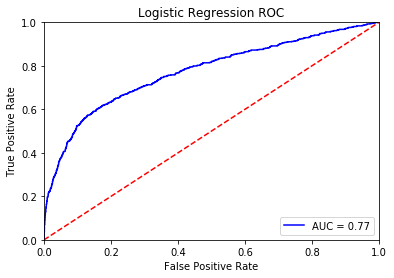

In [8]:
# visualize the curve

# calculate the fpr and tpr for all thresholds of the classification
probs = lr_model.predict_proba(X_test_std)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
plt.title('Logistic Regression ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2. LightGBM

In [9]:
# define the model with parameters from `04_tune.ipynb`
lgb_model = lgb.LGBMClassifier(
    random_state=2021, 
    objective='binary',
    num_leaves=10,
    max_depth=11,
    learning_rate=0.01,
    n_estimators=900) 

# fit the model
lgb_model.fit(X_train_std, y_train)

LGBMClassifier(learning_rate=0.01, max_depth=11, n_estimators=900,
               num_leaves=10, objective='binary', random_state=2021)

In [10]:
# predictions  
y_predict_train = lgb_model.predict_proba(X_train_std)
y_predict_valid = lgb_model.predict_proba(X_valid_std)
y_predict_test = lgb_model.predict_proba(X_test_std)

# AUC scores
train_score_lgb = roc_auc_score(y_train, y_predict_train[:,1])
valid_score_lgb = roc_auc_score(y_valid, y_predict_valid[:,1])
test_score_lgb = roc_auc_score(y_test, y_predict_test[:,1])
print("Training ROC-AUC score of LightGBM model: ", train_score_lgb)
print("Validation ROC-AUC score of LightGBM model: ", valid_score_lgb)
print("Test ROC-AUC score of LightGBM model: ", test_score_lgb)

Training ROC-AUC score of LightGBM model:  0.8366473202026334
Validation ROC-AUC score of LightGBM model:  0.8030689360926009
Test ROC-AUC score of LightGBM model:  0.7804982196161281


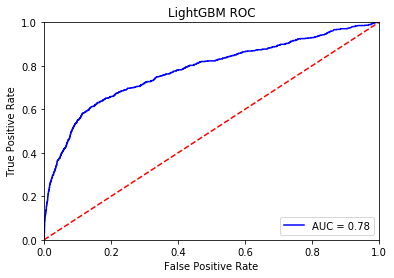

In [11]:
# visualize the curve

# calculate the fpr and tpr for all thresholds of the classification
probs = lgb_model.predict_proba(X_test_std)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
plt.title('LightGBM ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3. XGBoost

In [12]:
# define the model with parameters from `04_tune.ipynb`
xgb_model = xgb.XGBClassifier(
    random_state=2021, 
    learning_rate=0.025,
    n_estimators=100,
    max_depth=10,
    min_child_weight=7,
    subsample=0.7,
    colsample_bytree=0.6, 
    verbosity=0
) 

# fit the model
xgb_model.fit(X_train_std, y_train)

/Users/rachel/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.025, max_delta_step=0, max_depth=10,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=0)

In [13]:
# predictions
y_predict_train = xgb_model.predict_proba(X_train_std)
y_predict_valid = xgb_model.predict_proba(X_valid_std)
y_predict_test = xgb_model.predict_proba(X_test_std)

# AUC scores
train_score_xgb = roc_auc_score(y_train, y_predict_train[:,1])
valid_score_xgb = roc_auc_score(y_valid, y_predict_valid[:,1])
test_score_xgb = roc_auc_score(y_test, y_predict_test[:,1])
print("Training ROC-AUC score of XGBoost model: ", train_score_xgb)
print("Validation ROC-AUC score of XGBoost model: ", valid_score_xgb)
print("Test ROC-AUC score of XGBoost model: ", test_score_xgb)

Training ROC-AUC score of XGBoost model:  0.854777113150471
Validation ROC-AUC score of XGBoost model:  0.8074324350731832
Test ROC-AUC score of XGBoost model:  0.7825368850918739


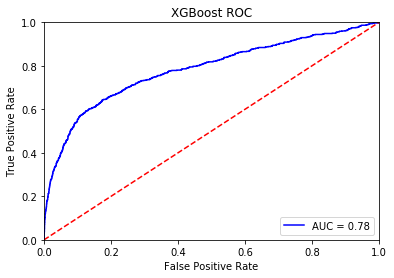

In [14]:
# visualize the curve

# calculate the fpr and tpr for all thresholds of the classification
probs = xgb_model.predict_proba(X_test_std)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
plt.title('XGBoost ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 4. Random Forest

In [15]:
# define the model with parameters from `04_tune.ipynb`
rf_model = RandomForestClassifier(
    random_state=2021, 
    n_estimators = 500, 
    max_features = 15,
    max_depth = 10
) 

# fit the model
rf_model.fit(X_train_std, y_train)

RandomForestClassifier(max_depth=10, max_features=15, n_estimators=500,
                       random_state=2021)

In [16]:
# predictions
y_predict_train = rf_model.predict_proba(X_train_std)
y_predict_valid = rf_model.predict_proba(X_valid_std)
y_predict_test = rf_model.predict_proba(X_test_std)

# AUC scores
train_score_rf = roc_auc_score(y_train, y_predict_train[:,1])
valid_score_rf = roc_auc_score(y_valid, y_predict_valid[:,1])
test_score_rf = roc_auc_score(y_test, y_predict_test[:,1])
print("Training ROC-AUC score of Random Forest model: ", train_score_rf)
print("Validation ROC-AUC score of Random Forest model: ", valid_score_rf)
print("Test ROC-AUC score of Random Forest model: ", test_score_rf)

Training ROC-AUC score of Random Forest model:  0.8752111136403355
Validation ROC-AUC score of Random Forest model:  0.8051141552511416
Test ROC-AUC score of Random Forest model:  0.7799844551257704


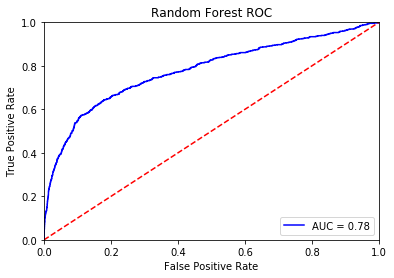

In [17]:
# visualize the curve

# calculate the fpr and tpr for all thresholds of the classification
probs = rf_model.predict_proba(X_test_std)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
plt.title('Random Forest ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## summary

In [18]:
summary = {
    'model':['Logistic Regression', 'LightGBM', 'XGBoost', 'Random Forest'],
    'Train ROC-AUC score':[train_score_lr, train_score_lgb, train_score_xgb, train_score_rf],
    'Validation ROC-AUC score':[valid_score_lr, valid_score_lgb, valid_score_xgb, valid_score_rf],
    'Test ROC-AUC score':[test_score_lr, test_score_lgb, test_score_xgb, test_score_rf]
}

pd.DataFrame(summary)

,model,Train ROC-AUC score,Validation ROC-AUC score,Test ROC-AUC score
0,Logistic Regression,0.801587,0.791295,0.773089
1,LightGBM,0.836647,0.803069,0.780498
2,XGBoost,0.854777,0.807432,0.782537
3,Random Forest,0.875211,0.805114,0.779984


## results
- The Random Forest model is not the best model of this group. It doesn't have the highest test score, and it overfits the most.
- It's debatable which of the remaining 3 models could be considered the best one. While XGBoost has the highest test score, it also overfits more than LightGBM or Logistic Regression.